In [18]:
import datetime as dt

class Timer():

	def __init__(self):
		self.start_dt = None

	def start(self):
		self.start_dt = dt.datetime.now()

	def stop(self):
		end_dt = dt.datetime.now()
		print('Time taken: %s' % (end_dt - self.start_dt))
  


In [5]:
!pip install -U -q PyDrive
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# choose a local (colab) directory to store the data.
local_download_path = os.path.expanduser('~/data')
try:
  os.makedirs(local_download_path)
except: pass

# 2. Auto-iterate using the query syntax
#    https://developers.google.com/drive/v2/web/search-parameters
file_list = drive.ListFile(
    {'q': "'1SooKSw8M4ACbznKjnNrYvJ5wxuqJ-YCk' in parents"}).GetList()





NameError: ignored

In [7]:
for f in file_list:
  # 3. Create & download by id.
  print('title: %s, id: %s' % (f['title'], f['id']))
  fname = os.path.join(local_download_path, f['title'])
  print('downloading to {}'.format(fname))
  f_ = drive.CreateFile({'id': f['id']})
  f_.GetContentFile(fname)


In [10]:
with open("/content/drive/MyDrive/Colab Notebooks/Spring board/config2.json", 'r') as f:
  #print(f.read())
  config = f.read()
  print(config)


{
	"data": {
		"filename": "sp500.csv",
		"columns": [
			"Close",
			"Volume"
		],
		"sequence_length": 50,
		"train_test_split": 0.85,
		"normalise": true
	},
	"training": {
		"epochs": 2,
		"batch_size": 32
	},
	"model": {
		"loss": "mse",
		"optimizer": "adam",
		"save_dir": "saved_models",
		"layers": [
			{
				"type": "lstm",
				"neurons": 100,
				"input_timesteps": 49,
				"input_dim": 2,
				"return_seq": true
			},
			{
				"type": "dropout",
				"rate": 0.2
			},
			{
				"type": "lstm",
				"neurons": 100,
				"return_seq": true
			},
			{
				"type": "lstm",
				"neurons": 100,
				"return_seq": false
			},
			{
				"type": "dropout",
				"rate": 0.2
			},
			{
				"type": "dense",
				"neurons": 1,
				"activation": "linear"
			}
		]
	}
}


In [23]:
import math
import numpy as np
import pandas as pd

class DataLoader():
    """A class for loading and transforming data for the lstm model"""

    def __init__(self, filename, split, cols):
        dataframe = pd.read_csv(filename)
        i_split = int(len(dataframe) * split)
        self.data_train = dataframe.get(cols).values[:i_split]
        self.data_test  = dataframe.get(cols).values[i_split:]
        self.len_train  = len(self.data_train)
        self.len_test   = len(self.data_test)
        self.len_train_windows = None

    def get_test_data(self, seq_len, normalise):
        '''
        Create x, y test data windows
        Warning: batch method, not generative, make sure you have enough memory to
        load data, otherwise reduce size of the training split.
        '''
        data_windows = []
        for i in range(self.len_test - seq_len):
            data_windows.append(self.data_test[i:i+seq_len])

        data_windows = np.array(data_windows).astype(float)
        data_windows = self.normalise_windows(data_windows, single_window=False) if normalise else data_windows

        x = data_windows[:, :-1]
        y = data_windows[:, -1, [0]]
        return x,y

    def get_train_data(self, seq_len, normalise):
        '''
        Create x, y train data windows
        Warning: batch method, not generative, make sure you have enough memory to
        load data, otherwise use generate_training_window() method.
        '''
        data_x = []
        data_y = []
        for i in range(self.len_train - seq_len):
            x, y = self._next_window(i, seq_len, normalise)
            data_x.append(x)
            data_y.append(y)
        return np.array(data_x), np.array(data_y)

    def generate_train_batch(self, seq_len, batch_size, normalise):
        '''Yield a generator of training data from filename on given list of cols split for train/test'''
        i = 0
        while i < (self.len_train - seq_len):
            x_batch = []
            y_batch = []
            for b in range(batch_size):
                if i >= (self.len_train - seq_len):
                    # stop-condition for a smaller final batch if data doesn't divide evenly
                    yield np.array(x_batch), np.array(y_batch)
                    i = 0
                x, y = self._next_window(i, seq_len, normalise)
                x_batch.append(x)
                y_batch.append(y)
                i += 1
            yield np.array(x_batch), np.array(y_batch)

    def _next_window(self, i, seq_len, normalise):
        '''Generates the next data window from the given index location i'''
        window = self.data_train[i:i+seq_len]
        window = self.normalise_windows(window, single_window=True)[0] if normalise else window
        x = window[:-1]
        y = window[-1, [0]]
        return x, y

    def normalise_windows(self, window_data, single_window=False):
        '''Normalise window with a base value of zero'''
        normalised_data = []
        window_data = [window_data] if single_window else window_data
        for window in window_data:
            normalised_window = []
            for col_i in range(window.shape[1]):
                normalised_col = [((float(p) / float(window[0, col_i])) - 1) for p in window[:, col_i]]
                normalised_window.append(normalised_col)
            normalised_window = np.array(normalised_window).T # reshape and transpose array back into original multidimensional format
            normalised_data.append(normalised_window)
        return np.array(normalised_data)
    

In [19]:
import os
import math
import numpy as np
import datetime as dt
from numpy import newaxis


#from pyping.utils import Timer
#from core.utils import Timer
#import Timer
from keras.layers import Dense, Activation, Dropout, LSTM
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint

class Model():
	"""A class for an building and inferencing an lstm model"""

	def __init__(self):
		self.model = Sequential()

	def load_model(self, filepath):
		print('[Model] Loading model from file %s' % filepath)
		self.model = load_model(filepath)

	def build_model(self, configs):
		timer = Timer()
		timer.start()

		for layer in configs['model']['layers']:
			neurons = layer['neurons'] if 'neurons' in layer else None
			dropout_rate = layer['rate'] if 'rate' in layer else None
			activation = layer['activation'] if 'activation' in layer else None
			return_seq = layer['return_seq'] if 'return_seq' in layer else None
			input_timesteps = layer['input_timesteps'] if 'input_timesteps' in layer else None
			input_dim = layer['input_dim'] if 'input_dim' in layer else None

			if layer['type'] == 'dense':
				self.model.add(Dense(neurons, activation=activation))
			if layer['type'] == 'lstm':
				self.model.add(LSTM(neurons, input_shape=(input_timesteps, input_dim), return_sequences=return_seq))
			if layer['type'] == 'dropout':
				self.model.add(Dropout(dropout_rate))

		self.model.compile(loss=configs['model']['loss'], optimizer=configs['model']['optimizer'])

		print('[Model] Model Compiled')
		timer.stop()

	def train(self, x, y, epochs, batch_size, save_dir):
		timer = Timer()
		timer.start()
		print('[Model] Training Started')
		print('[Model] %s epochs, %s batch size' % (epochs, batch_size))
		
		save_fname = os.path.join(save_dir, '%s-e%s.h5' % (dt.datetime.now().strftime('%d%m%Y-%H%M%S'), str(epochs)))
		callbacks = [
			EarlyStopping(monitor='val_loss', patience=2),
			ModelCheckpoint(filepath=save_fname, monitor='val_loss', save_best_only=True)
		]
		self.model.fit(
			x,
			y,
			epochs=epochs,
			batch_size=batch_size,
			callbacks=callbacks
		)
		self.model.save(save_fname)

		print('[Model] Training Completed. Model saved as %s' % save_fname)
		timer.stop()

	def train_generator(self, data_gen, epochs, batch_size, steps_per_epoch, save_dir):
		timer = Timer()
		timer.start()
		print('[Model] Training Started')
		print('[Model] %s epochs, %s batch size, %s batches per epoch' % (epochs, batch_size, steps_per_epoch))
		
		save_fname = os.path.join(save_dir, '%s-e%s.h5' % (dt.datetime.now().strftime('%d%m%Y-%H%M%S'), str(epochs)))
		callbacks = [
			ModelCheckpoint(filepath=save_fname, monitor='loss', save_best_only=True)
		]
		self.model.fit_generator(
			data_gen,
			steps_per_epoch=steps_per_epoch,
			epochs=epochs,
			callbacks=callbacks,
			workers=1
		)
		
		print('[Model] Training Completed. Model saved as %s' % save_fname)
		timer.stop()

	def predict_point_by_point(self, data):
		#Predict each timestep given the last sequence of true data, in effect only predicting 1 step ahead each time
		print('[Model] Predicting Point-by-Point...')
		predicted = self.model.predict(data)
		predicted = np.reshape(predicted, (predicted.size,))
		return predicted

	def predict_sequences_multiple(self, data, window_size, prediction_len):
		#Predict sequence of 50 steps before shifting prediction run forward by 50 steps
		print('[Model] Predicting Sequences Multiple...')
		prediction_seqs = []
		for i in range(int(len(data)/prediction_len)):
			curr_frame = data[i*prediction_len]
			predicted = []
			for j in range(prediction_len):
				predicted.append(self.model.predict(curr_frame[newaxis,:,:])[0,0])
				curr_frame = curr_frame[1:]
				curr_frame = np.insert(curr_frame, [window_size-2], predicted[-1], axis=0)
			prediction_seqs.append(predicted)
		return prediction_seqs

	def predict_sequence_full(self, data, window_size):
		#Shift the window by 1 new prediction each time, re-run predictions on new window
		print('[Model] Predicting Sequences Full...')
		curr_frame = data[0]
		predicted = []
		for i in range(len(data)):
			predicted.append(self.model.predict(curr_frame[newaxis,:,:])[0,0])
			curr_frame = curr_frame[1:]
			curr_frame = np.insert(curr_frame, [window_size-2], predicted[-1], axis=0)
		return predicted

In [ ]:
#!apt-get install python3.7

In [ ]:
!pip install tensorflow

In [32]:
configs = json.load(open('/content/drive/MyDrive/Colab Notebooks/Spring board/config2.json', 'r'))

data = DataLoader(
	os.path.join('/content/drive/MyDrive/Colab Notebooks/Spring board/data', configs['data']['filename']),
	configs['data']['train_test_split'],
	configs['data']['columns']
)

model = Model()
model.build_model(configs)
x, y = data.get_train_data(
	seq_len = configs['data']['sequence_length'],
	normalise = configs['data']['normalise']
)

model.train(
	x,
	y,
	epochs = configs['training']['epochs'],
	batch_size = configs['training']['batch_size'], save_dir = "/content/drive/MyDrive/Colab Notebooks/Spring board/data"
)

x_test, y_test = data.get_test_data(
	seq_len = configs['data']['sequence_length'],
	normalise = configs['data']['normalise']
)

[Model] Model Compiled
Time taken: 0:00:00.792337
[Model] Training Started
[Model] 2 epochs, 32 batch size
Epoch 1/2
124/124 [==============================] - 17s 102ms/step - loss: 0.0016
Epoch 2/2
124/124 [==============================] - 14s 110ms/step - loss: 5.2222e-04
[Model] Training Completed. Model saved as /content/drive/MyDrive/Colab Notebooks/Spring board/data/23042021-203405-e2.h5
Time taken: 0:00:30.813902


In [ ]:
#!pip3 install i3pystatus

In [ ]:
#import time
import tensorflow as tf
from tensorflow.python.keras.layers import Input, Dense
from tensorflow import keras
from tensorflow.keras import layers


import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.layers import Dropout

In [21]:
def predict_point_by_point(self, data):
	#Predict each timestep given the last sequence of true data, in effect only predicting 1 step ahead each time
	predicted = self.model.predict(data)
  
	predicted = np.reshape(predicted, (predicted.size, ))
	return predicted

def predict_sequence_full(self, data, window_size):
	#Shift the window by 1 new prediction each time, re-run predictions on new window
	curr_frame = data[0]
	predicted = []
	for i in range(len(data)):
		predicted.append(self.model.predict(curr_frame[newaxis,:,:])[0,0])
		curr_frame = curr_frame[1:]
		curr_frame = np.insert(curr_frame, [window_size-2], predicted[-1], axis=0)
	return predicted




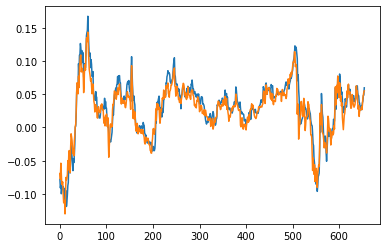

In [34]:
predictions_pointbypoint = predict_point_by_point(model, x_test)
#plot_results(predictions_pointbypoint, y_test)
plt.plot(predictions_pointbypoint)
plt.plot(y_test)



In [ ]:
#y_test

[Model] Predicting Sequences Full...


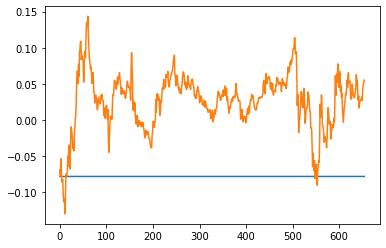

In [38]:
#predictions_fullseq = model.predict_sequence_full(x_test, configs['data']['sequence_length'])
#plot_results(predictions_fullseq, y_test)
predictions_fullseq = model.predict_sequence_full(x_test, 2)


plt.plot(predictions_fullseq)
plt.plot(y_test)

[Model] Model Compiled
Time taken: 0:00:00.862198
[Model] Training Started
[Model] 2 epochs, 32 batch size, 124 batches per epoch
Epoch 1/2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


124/124 [==============================] - 18s 107ms/step - loss: 0.0030
Epoch 2/2
124/124 [==============================] - 14s 112ms/step - loss: 8.8409e-04
[Model] Training Completed. Model saved as saved_models/23042021-203140-e2.h5
Time taken: 0:00:31.846147
[Model] Predicting Sequences Multiple...


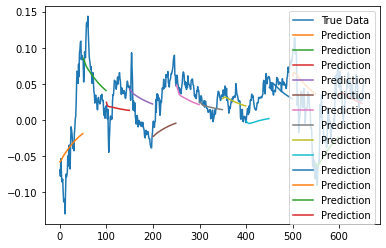

In [29]:
import os
import json
import time
import math
import matplotlib.pyplot as plt
#from core.data_processor import DataLoader
#from core.model import Model


def plot_results(predicted_data, true_data):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    plt.plot(predicted_data, label='Prediction')
    plt.legend()
    plt.show()


def plot_results_multiple(predicted_data, true_data, prediction_len):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
	# Pad the list of predictions to shift it in the graph to it's correct start
    for i, data in enumerate(predicted_data):
        padding = [None for p in range(i * prediction_len)]
        plt.plot(padding + data, label='Prediction')
        plt.legend()
    plt.show()


def main():
    configs = json.load(open('/content/drive/MyDrive/Colab Notebooks/Spring board/config2.json', 'r'))
    if not os.path.exists(configs['model']['save_dir']): os.makedirs(configs['model']['save_dir'])

    data = DataLoader(
        os.path.join('/content/drive/MyDrive/Colab Notebooks/Spring board/data', configs['data']['filename']),
        configs['data']['train_test_split'],
        configs['data']['columns']
    )

    model = Model()
    model.build_model(configs)
    x, y = data.get_train_data(
        seq_len=configs['data']['sequence_length'],
        normalise=configs['data']['normalise']
    )

    '''
	# in-memory training
	model.train(
		x,
		y,
		epochs = configs['training']['epochs'],
		batch_size = configs['training']['batch_size'],
		save_dir = configs['model']['save_dir']
	)
	'''
    # out-of memory generative training
    steps_per_epoch = math.ceil((data.len_train - configs['data']['sequence_length']) / configs['training']['batch_size'])
    model.train_generator(
        data_gen=data.generate_train_batch(
            seq_len=configs['data']['sequence_length'],
            batch_size=configs['training']['batch_size'],
            normalise=configs['data']['normalise']
        ),
        epochs=configs['training']['epochs'],
        batch_size=configs['training']['batch_size'],
        steps_per_epoch=steps_per_epoch,
        save_dir=configs['model']['save_dir']
    )

    x_test, y_test = data.get_test_data(
        seq_len=configs['data']['sequence_length'],
        normalise=configs['data']['normalise']
    )

    predictions = model.predict_sequences_multiple(x_test, configs['data']['sequence_length'], configs['data']['sequence_length'])
    # predictions = model.predict_sequence_full(x_test, configs['data']['sequence_length'])
    # predictions = model.predict_point_by_point(x_test)

    plot_results_multiple(predictions, y_test, configs['data']['sequence_length'])
    # plot_results(predictions, y_test)


if __name__ == '__main__':
    main()

In [ ]:
{
	"data": {
		"filename": "sinewave.csv",
		"columns": [
			"sinewave"
		],
		"sequence_length": 50,
		"train_test_split": 0.8,
		"normalise": false
	},
	"training": {
		"epochs": 2,
		"batch_size": 32
	},
	"model": {
		"loss": "mse",
		"optimizer": "adam",
		"layers": [
			{
				"type": "lstm",
				"neurons": 50,
				"input_timesteps": 49,
				"input_dim": 1,
				"return_seq": true
			},
			{
				"type": "dropout",
				"rate": 0.05
			},
			{
				"type": "lstm",
				"neurons": 100,
				"return_seq": false
			},
			{
				"type": "dropout",
				"rate": 0.05
			},
			{
				"type": "dense",
				"neurons": 1,
				"activation": "linear"
			}
		]
	}
}

In [ ]:
{
	"data": {
		"filename": "sp500.csv",
		"columns": [
			"Close",
			"Volume"
		],
		"sequence_length": 50,
		"train_test_split": 0.85,
		"normalise": true
	},
	"training": {
		"epochs": 2,
		"batch_size": 32
	},
	"model": {
		"loss": "mse",
		"optimizer": "adam",
		"save_dir": "saved_models",
		"layers": [
			{
				"type": "lstm",
				"neurons": 100,
				"input_timesteps": 49,
				"input_dim": 2,
				"return_seq": true
			},
			{
				"type": "dropout",
				"rate": 0.2
			},
			{
				"type": "lstm",
				"neurons": 100,
				"return_seq": true
			},
			{
				"type": "lstm",
				"neurons": 100,
				"return_seq": false
			},
			{
				"type": "dropout",
				"rate": 0.2
			},
			{
				"type": "dense",
				"neurons": 1,
				"activation": "linear"
			}
		]
	}
}